## Local XGBoost Training Models using native CV for cross validation Experiment (Features and Parameters research

Purpose: Based on the configured list of features and/or parameters train several models to compare results. Native XGBoost CV function is used to perform cross validation.

The idea is to do a deep model comparison with the same method (XGBoost Classification), target variable and dataset but different sets of features and/or parameters.

The output is not just a model and score but also feature importance, test dataset evaluation score and training/validation errors to analyze overfitting.

#### Notebook Main steps:

1. Experiment configuration. Instead of hardcoding datafile name, target variable, featuresets and parameters sets directly in the code I use an Excel file. Each tab with a predefined name contains featuresets for each model or parameter sets, etc. At the end, the code records the results back into the same excel file. Excel is used as an UI to easily configure experiment and simplify re-use of this notebook

2. Preparing training and validation datasets - data preprocessing. If the datasets can be re-used from a previous experiment, only a location to the files can be configured instead. Usually, testing different featuretests requires creation individual datasets per testing model and different parameters can be tested on the same dataset. The preprocessed datasets are saved in order to re-use in other experiments. Folds are NOT created at this moment. It's done in XGBoost CV.

3. CV for each model.

4. Extracting results, visualization, performing t-test and saving to an experiment log file. This is done for averaged results from all folds per model. 


In [1]:
temp_folder='/home/kate/Research/Property/Notebooks/Experiments/tmp/'
#Experiment_name must NOT contain underscore (_)
Experiment_name='Other3'
#Experiments log file 
Experiments_file='/home/kate/Research/Property/Notebooks/Experiments/Logs/Set2-Classification.xlsx'
#AllExperiments_tab is a table with a list of all experiments included in the log
#Mandatory columns: Experiment (Experiment_name), Dataset(data file name), Target(target column name from Dataset)
#The rest of the columns are not use in the code below. I usually add in a free form: objective,status,result,notebook name used to conduct the experiment
AllExperiments_tab='Experiments'
#Experiment configuration:
#1.Experiment_Features_tab: differenet datasets to try
#each line in the tab contains a model name and set of features to built a dataset for SageMaker
#a feature can be an exact column name from the Dataset column in AllExperiments_tab or a calculation based on exact column names and eval pandas function
#if the experiment objective is to try different parameters sets, all models (if more then 1) can have the same feature sets.
Experiment_Features_tab='%s Features'%Experiment_name
#2. Alternatively a set of data files with preprocessed data in S3 can be provided in a form:
#Model,Training_data,Validation_data[, Testing_data, Testing_labels]
Experiment_InputData_tab='%s InputData'%Experiment_name
#3. Experiment_Params_tab: each line in the tab contains a model name and set of XGBoost parametersto apply to a model
#the set of models should be consistent in Experiment_Features_tab and Experiment_Params_tab
#parameters can be the same for all models or specific in each model
Experiment_Params_tab='%s Params'%Experiment_name




path_to_data='/home/kate/Research/Property/Data/'
path_to_models='/home/kate/Research/Property/Models/Experiments/%s/'%Experiment_name

path_to_training_data='/home/kate/Research/Property/Data/Experiments/%s/training/'%Experiment_name
path_to_testing_data='/home/kate/Research/Property/Data/Experiments/%s/testing/'%Experiment_name



#preprocessing parameters - the year to separate test data
split_year=2019



#number of folds for CV
num_folds=10



#level of details returning from CV
#any Y return models from a best iteration
#FeatureImportance Y/N
GetFIFlg='Y'
#Scores for Test data (should be provided in fit "test" input) Y/N
GetTestScoreFlg='Y'
#Prediction of Test data (should be provided in fit "test" input) Y/N
GetTestPredFlg='Y'  

score='gini' #'poisson-nloglik' #'gini' #AUC


#Significance level for t-test
alpha=0.05

#n2/n1 (validation/training) ratio for corrected t-test if n2=n1 or n2/n1 = 1 then it's just usual Student t-test withoot correction
#10 folds means 1/9 validation/training ratio 
n2=1
n1=9

In [2]:
import sys
import time
import os

import re

import pandas as pd
import numpy as np

import xgboost as xgb
import pickle as pkl

#for analyzing results: charts and t-test
import scipy.stats as stats
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Experiment
Experiment is configured in an experiment log file (Excel file, in my case,  in different tabs)

1. Reading an experiment configuration (Experiment_name) from an experiment log file (Experiments_file). Target and Dataset columns in AllExperiments_tab contain data file name used and target column

In [3]:
experiments = pd.read_excel(open(Experiments_file, 'rb'), sheet_name=AllExperiments_tab)

In [4]:
target=experiments[experiments['Experiment']==Experiment_name]['Target'].values[0]
print('Target of models in %s experiment is %s'%(Experiment_name,target))
data_file=experiments[experiments['Experiment']==Experiment_name]['Dataset'].values[0]
print('Datafile used in %s experiment is %s'%(Experiment_name,data_file))

Target of models in Other3 experiment is hasclaim
Datafile used in Other3 experiment is property_water_claims_non_cat_fs_v7.csv


2. Models based on individual datasets to be created, trained and compared in the experiment (Experiment_Features_tab) is a table with first column Model name (should be unique) and next columns [1:51] features to train the model. Feature is the exact column name from the dataset or a calculation based on exact column names and eval pandas function

This configuration will be used to preprocess data and also need to be moved to S3 in csv format for easy reading in a preprocessing script if we use AWS SKLearnProcessor/job/instances

In [5]:
model_features = pd.read_excel(open(Experiments_file, 'rb'), sheet_name=Experiment_Features_tab)
model_features  

,Model,F1,F2,F3,F4,F5,F6
0,Model1,sqft,usagetype_encd,yearbuilt,water_risk_3_blk,customer_cnt_active_policies,cova_deductible
1,Model2,sqft,usagetype_encd,cal_year-yearbuilt,water_risk_3_blk,customer_cnt_active_policies,cova_deductible


2a.Preprocessed data may already exists in an S3. Experiment configuration can provide the list of files per model. In this case (len(preprocessed_data)==0) the code skips all steps to preprocess data

In [6]:
try:
    preprocessed_data = pd.read_excel(open(Experiments_file, 'rb'), sheet_name=Experiment_InputData_tab)
    #preprocessed_data = pd.concat([preprocessed_data,model_features.drop('Model',axis=1)], axis=1)
except:
    preprocessed_data = pd.DataFrame()

3. Model params to be used in training is a table with first column Model name (should be unique and corresponds to models in Experiment_Features_tab) and next columns are XGBoost parameters
In a general case, all models can have the same parameters

In [7]:
model_params = pd.read_excel(open(Experiments_file, 'rb'), sheet_name=Experiment_Params_tab)
model_params

,Model,objective,eval_metric,booster,scale_pos_weight,colsample_bylevel,colsample_bytree,eta,subsample,max_depth,num_round,reg_lambda,reg_alpha
0,Model1,binary:logistic,auc,gbtree,0.3,0.8,0.8,0.06946,0.300709,4,5000,1,0.514599
1,Model2,binary:logistic,auc,gbtree,0.3,0.8,0.8,0.06946,0.300709,4,5000,1,0.514599


4.Verification if we have the same set of models in both configurations

In [8]:
models_from_model_features=model_features['Model'].tolist()
models_from_model_params=model_params['Model'].tolist()
if len([x for x in models_from_model_features if x not in models_from_model_params])!=0:
    raise Exception('Different set of models in featuresets and parametersets!')
if len(preprocessed_data)>0:
    models_from_preprocessed_data=preprocessed_data['Model'].tolist()
    if len([x for x in models_from_preprocessed_data if x not in models_from_model_params])!=0:
        raise Exception('Different set of models in input data and parametersets!')

In [9]:
#sys.path.append('/home/kate/Research/YearBuilt/Notebooks/Experiments')
import ExperimentsUtils as eu

## Data preprocessing

Preprocessing output (training and testing datasets) are saved separately for each model in a folder with the same name as a models name configured in the experiment

In [10]:
if len(preprocessed_data)==0:
    preprocessed_data = pd.DataFrame(columns=['Model', 'Training_data',  'Testing_data', 'Training_offset','Testing_offset'])
    
    input_data_path=path_to_data+data_file
    print('Reading input data from {}'.format(input_data_path))
    dataset = pd.read_csv(input_data_path, error_bad_lines=False, index_col=False)
    
    dataset_test=dataset[(dataset.cal_year == split_year)]
    dataset=dataset[(dataset.cal_year < split_year)]    
    
 
    

    #iterating thru config file with models and featureset
    feature_columns=model_features.columns.tolist()
    try:
        feature_columns.remove('Offset')
    except:
        pass
    feature_columns.remove('Model')
    feature_columns
    for index, row in model_features.iterrows():
        model=row['Model']
        print (index, ': Creating datasets for model %s'%model)
        featureset=row[feature_columns].tolist()

        
        featureset=[x for x in featureset if str(x) != 'nan']
        print(','.join(featureset))
        
        #creating dataset for a model according to configured dataset
        X = pd.DataFrame()
        X_test = pd.DataFrame()        
        for f in featureset:
            X[f]=dataset.eval(f)
            X_test[f]=dataset_test.eval(f)             
        y=dataset.eval(target)
        y_test=dataset_test.eval(target) 
        
        #Offset is not a mandatory column
        offset_flg=False
        test_offset_filename=''
        train_offset_filename=''
        try:
            offset_column=row['Offset']
            if offset_column != 'nan':
                offset_train=dataset.eval(offset_column)
                offset_test=dataset_test.eval(offset_column)            
                offset_flg=True
        except:
            offset_flg=False
        
        
        print('Testing data...')
        
        test_dataset=pd.DataFrame({target:y_test}).join(X_test)
        
        test_data_output_path = path_to_testing_data+model              
        if not os.path.exists(test_data_output_path):
            os.makedirs(test_data_output_path) 
        test_data_filename = os.path.join(test_data_output_path,  'testing_%s.csv'%(model)) 
        test_dataset.to_csv(test_data_filename, header=True, index=False)
        if offset_flg:
            test_offset_filename = os.path.join(test_data_output_path,  'offset_%s.csv'%(model))
            offset_test.to_csv(test_offset_filename, header=True, index=False)
        #The rest of the data will be used in cv-fold as a whole and seprated to training/validation insode cv  
        print('Training data...')
        training_dataset=pd.DataFrame({target:y}).join(X)
 
        train_data_output_path=path_to_training_data+model
        if not os.path.exists(train_data_output_path):
            os.makedirs(train_data_output_path)
        train_data_filename = os.path.join(train_data_output_path, 'training_%s.csv'%model) 
        training_dataset.to_csv(train_data_filename, header=True, index=False)   

        if offset_flg:
            train_offset_filename = os.path.join(train_data_output_path,  'offset_%s.csv'%(model))
            offset_train.to_csv(train_offset_filename, header=True, index=False)
            
        preprocessed_data.loc[index]=[model, train_data_filename,test_data_filename,train_offset_filename,test_offset_filename]
        
    #Saving into the Experiment log file names of created training and validation datasets
    preprocessed_data = pd.concat([preprocessed_data,model_features.drop('Model',axis=1)], axis=1) 
    eu.SaveToExperimentLog(Experiments_file, '%s InputData'%Experiment_name, preprocessed_data)

Reading input data from /home/kate/Research/Property/Data/property_water_claims_non_cat_fs_v7.csv
0 : Creating datasets for model Model1
sqft,usagetype_encd,yearbuilt,water_risk_3_blk,customer_cnt_active_policies,cova_deductible
Testing data...
Training data...
1 : Creating datasets for model Model2
sqft,usagetype_encd,cal_year-yearbuilt,water_risk_3_blk,customer_cnt_active_policies,cova_deductible
Testing data...
Training data...


In [11]:
preprocessed_data

,Model,Training_data,Testing_data,Training_offset,Testing_offset,F1,F2,F3,F4,F5,F6
0,Model1,/home/kate/Research/Property/Data/Experiments/...,/home/kate/Research/Property/Data/Experiments/...,,,sqft,usagetype_encd,yearbuilt,water_risk_3_blk,customer_cnt_active_policies,cova_deductible
1,Model2,/home/kate/Research/Property/Data/Experiments/...,/home/kate/Research/Property/Data/Experiments/...,,,sqft,usagetype_encd,cal_year-yearbuilt,water_risk_3_blk,customer_cnt_active_policies,cova_deductible


## Model training

In [12]:
models_from_preprocessed_data=preprocessed_data['Model'].tolist()
models_from_model_params=model_params['Model'].tolist()
if len([x for x in models_from_preprocessed_data if x not in models_from_model_params])!=0:
    raise Exception('Different set of models in preprocessed_data and parametersets!')
#using merge because, in general, we can have different number of rows in each dataframe - folds in data and different sets of params
data_for_training=pd.merge(model_params, preprocessed_data, on='Model', how='inner')
data_for_training

,Model,objective,eval_metric,booster,scale_pos_weight,colsample_bylevel,colsample_bytree,eta,subsample,max_depth,...,Training_data,Testing_data,Training_offset,Testing_offset,F1,F2,F3,F4,F5,F6
0,Model1,binary:logistic,auc,gbtree,0.3,0.8,0.8,0.06946,0.300709,4,...,/home/kate/Research/Property/Data/Experiments/...,/home/kate/Research/Property/Data/Experiments/...,,,sqft,usagetype_encd,yearbuilt,water_risk_3_blk,customer_cnt_active_policies,cova_deductible
1,Model2,binary:logistic,auc,gbtree,0.3,0.8,0.8,0.06946,0.300709,4,...,/home/kate/Research/Property/Data/Experiments/...,/home/kate/Research/Property/Data/Experiments/...,,,sqft,usagetype_encd,cal_year-yearbuilt,water_risk_3_blk,customer_cnt_active_policies,cova_deductible


In [13]:
def cv_misc_callback(oof_train_scores:list, oof_valid_scores:list, best_models:list,  maximize=True):
    """
    It's called inside XGB CV to catch individual folds scores and models
    """    
    state = {}
    def init(env):
        if maximize:
            state['best_score'] = -np.inf
        else:
            state['best_score'] = np.inf 
#--------------------------------------------------------------------------------            
    def callback(env):
        #init env if empty
        if not state:
            init(env)
        best_score = state['best_score']
        score = env.evaluation_result_list[-1][1]
        #extract best model if a current score is better then previous
        if (maximize and score > best_score) or (not maximize and score < best_score):
            for i, cvpack in enumerate(env.cvfolds): 
                best_models[i]=cvpack.bst
            state['best_score'] = score    
        #all iterations individual folds scores
        folds_train_scores = []
        folds_valid_scores = []
        for i, cvpack in enumerate(env.cvfolds):    
            scores = cvpack.eval(iteration=0,feval=feval)
            #print(scores)
            scores_l = re.split(': |\t',scores)
            train_score=scores_l[1].rpartition(':')[2]
            valid_score=scores_l[2].rpartition(':')[2]
            folds_train_scores.append(train_score)
            folds_valid_scores.append(valid_score)
        oof_train_scores.append(folds_train_scores)
        oof_valid_scores.append(folds_valid_scores)
#--------------------------------------------------------------------------------        
    callback.before_iteration = False
    return callback

In [14]:
def gini(y, pred):
    g = np.asarray(np.c_[y, pred, np.arange(len(y)) ], dtype=np.float)
    g = g[np.lexsort((g[:,2], -1*g[:,1]))]
    gs = g[:,0].cumsum().sum() / g[:,0].sum()
    gs -= (len(y) + 1) / 2.
    return gs / len(y)
def gini_xgb(pred, y):
    y = y.get_label()
    return 'gini', gini(y, pred) / gini(y, y)

In [15]:
from sklearn.metrics import roc_auc_score

In [16]:
def nLogLik_XGBoost (act,pred):
    df = pd.DataFrame({"act":act,"pred":pred}) 
    return np.mean( df.pred - df.act*np.log(df.pred))

In [17]:
#parameters depending on score
#custom evaluation function
feval=gini_xgb if score=='gini' else None
#best model from xgboost CV: with minimum or maximum score
Maximize=False if score=='poisson-nloglik'  else True

In [18]:
#Running this cell can be skipped and used the results from the same Python code which was ran in background 
#regexpression to exclude features (F1..F25) from the list of parameters
regex = re.compile('F[ 0-9]')
for index, row in data_for_training.iterrows():
    model='%s-%s'%(row['Model'],index)
    print(model)
    
    #Dataset
    train_dataset = pd.read_csv(row['Training_data'], error_bad_lines=False, index_col=False)
    X_train = train_dataset.iloc[:,1:]
    y_train = train_dataset.iloc[:, 0]
    dtrain = xgb.DMatrix(X_train, y_train)
    #offset is not mandatory
    try:
        train_offset = pd.read_csv(row['Training_offset'], error_bad_lines=False, index_col=False)
        dtrain.set_base_margin(train_offset.values)
        print('training Offset was added')
    except:
        pass
    
    #Test Dataset
    if 'Y' in (GetTestScoreFlg,GetTestPredFlg):
        test_dataset = pd.read_csv(row['Testing_data'], error_bad_lines=False, index_col=False)
        X_test = test_dataset.iloc[:,1:]
        y_test = test_dataset.iloc[:, 0]
        dtest = xgb.DMatrix(X_test, y_test)
        #offset is not mandatory
        try:
            testing_offset = pd.read_csv(row['Testing_offset'], error_bad_lines=False, index_col=False)
            dtest.set_base_margin(testing_offset.values)
            print('testing Offset was added')            
        except:
            pass
    
    #Hyperparameters
    hyperparameters = {     
        'seed': 42       
    } 
    for i, param in enumerate(data_for_training.columns):
        #skip first column with Model name and dataset names or features
        #if do not exclude then they will be added into experiment analytics as parameters but not used in training anyway
        if ((param in ('Model','Training_data','Validation_data','Testing_data','Testing_labels','Offset','Training_offset', 'Testing_offset')) | (bool(re.match(regex, param)))):
            continue
        if param=='num_round':
            continue
        if ((param=='eval_metric') & (score=='gini')):
            hyperparameters['disable_default_eval_metric'] = '1'
            continue       
        hyperparameters[param] = row[param]
    print(hyperparameters)
    num_boost_round = row['num_round']
    early_stopping_rounds = 100
                        
                          
    #OUT parameters from custom callback function: 
    #train and valid scores from all folds
    oof_train_scores = []
    oof_valid_scores = []
    #Best Model
    best_models=[None]*num_folds
    #===========================================================================================================    
    args = {'params':hyperparameters, 
                  'dtrain':dtrain,             
                  'feval':feval,
                  'num_boost_round':num_boost_round,
                  'nfold':num_folds, 
                  'stratified':True, 
                  'shuffle':True,
                  'early_stopping_rounds':early_stopping_rounds, 
                  'seed':42,
                  'callbacks':[cv_misc_callback(oof_train_scores, oof_valid_scores,best_models,Maximize), xgb.callback.print_evaluation(period=10)]}     
    
    cv_results=xgb.cv(**args)

    #===========================================================================================================
    #scores to dataframe
    df_oof_train_scores = pd.DataFrame.from_records(oof_train_scores).apply(pd.to_numeric)
    df_oof_valid_scores = pd.DataFrame.from_records(oof_valid_scores).apply(pd.to_numeric)


    
    #only folds scores columns names
    columns = df_oof_train_scores.columns.tolist()

    
    #mean and std, sem 
    df_oof_train_scores['std'] = df_oof_train_scores[columns].std(axis=1)
    df_oof_valid_scores['std'] = df_oof_valid_scores[columns].std(axis=1)
    df_oof_train_scores['sem'] = df_oof_train_scores[columns].sem(axis=1)
    df_oof_valid_scores['sem'] = df_oof_valid_scores[columns].sem(axis=1)    
    df_oof_train_scores['mean'] = df_oof_train_scores[columns].mean(axis=1)
    df_oof_valid_scores['mean'] = df_oof_valid_scores[columns].mean(axis=1)
    
    #best models feature importance 
    if GetFIFlg=='Y':
        oof_fi_weight_best = {}
        oof_fi_gain_best = {}
        oof_fi_cover_best = {}
        for i in range(0,num_folds):
            oof_fi_weight_best[i]=best_models[i].get_score(importance_type='weight')
            oof_fi_gain_best[i]= best_models[i].get_score(importance_type='gain')
            oof_fi_cover_best[i]= best_models[i].get_score(importance_type='cover')
    
        #converting to dataframe
        df_oof_fi_weight_best = pd.DataFrame(oof_fi_weight_best).apply(pd.to_numeric)
        df_oof_fi_gain_best = pd.DataFrame(oof_fi_gain_best).apply(pd.to_numeric)
        df_oof_fi_cover_best = pd.DataFrame(oof_fi_cover_best).apply(pd.to_numeric)
    
    
        #mean and std, sem 
        df_oof_fi_weight_best['std'] = df_oof_fi_weight_best[columns].std(axis=1)
        df_oof_fi_gain_best['std'] = df_oof_fi_gain_best[columns].std(axis=1)
        df_oof_fi_cover_best['std'] = df_oof_fi_cover_best[columns].std(axis=1)
    
        df_oof_fi_weight_best['sem'] = df_oof_fi_weight_best[columns].sem(axis=1)
        df_oof_fi_gain_best['sem'] = df_oof_fi_gain_best[columns].sem(axis=1)
        df_oof_fi_cover_best['sem'] = df_oof_fi_cover_best[columns].sem(axis=1)
    
        df_oof_fi_weight_best['mean'] = df_oof_fi_weight_best[columns].mean(axis=1)
        df_oof_fi_gain_best['mean'] = df_oof_fi_gain_best[columns].mean(axis=1)
        df_oof_fi_cover_best['mean'] = df_oof_fi_cover_best[columns].mean(axis=1)
    
    
        #feature codes from index to column
        df_oof_fi_weight_best.reset_index(level=0, inplace=True)
        df_oof_fi_weight_best.columns=['feature'] + columns + ['std','sem','mean']
        df_oof_fi_gain_best.reset_index(level=0, inplace=True)
        df_oof_fi_gain_best.columns=['feature'] + columns + ['std','sem','mean']
        df_oof_fi_cover_best.reset_index(level=0, inplace=True)
        df_oof_fi_cover_best.columns=['feature'] + columns + ['std','sem','mean']
    
    if 'Y' in (GetTestScoreFlg,GetTestPredFlg):
        #Prediction on test data  from folds best models...
        df_prediction=pd.DataFrame()
        df_prediction['actual']=dtest.get_label()
        for i in range(0,num_folds):
            df_prediction[i]=best_models[i].predict(dtest)
   
        #Test scores from test prediction   
        df_scores = pd.DataFrame()
        for i in range(0,num_folds):
            if score=='gini':
                df_scores[i]=[gini(df_prediction['actual'], df_prediction[i])/gini(df_prediction['actual'], df_prediction['actual'])]
            elif score=='AUC':
                df_scores[i]=[roc_auc_score(df_prediction['actual'], df_prediction[i])]
            elif score=='poisson-nloglik':
                df_scores[i]=[nLogLik_XGBoost(df_prediction['actual'],df_prediction[i])]
                

        df_scores['std'] = df_scores[columns].std(axis=1)
        df_scores['sem'] = df_scores[columns].sem(axis=1)
        df_scores['mean'] = df_scores[columns].mean(axis=1)

    output_data_dir=path_to_models+model
    if not os.path.exists(output_data_dir):
        os.makedirs(output_data_dir)
            
        
    for i in range(0,num_folds):
        model_location = os.path.join(output_data_dir , 'model-fold-'+str(i))
        pkl.dump(best_models[i], open(model_location, 'wb'))
        
    if  GetTestPredFlg=='Y':    
        predictions_location = os.path.join(output_data_dir, 'test_predictions.csv')
        print('Saving test predictions at {}'.format(predictions_location))            
        df_prediction.to_csv(predictions_location, header=True, index=False)
        
    if  GetTestScoreFlg=='Y':
        oof_test_scores_location = os.path.join(output_data_dir, 'oof_test_scores.csv')
        print('Saving oof_test_scores at {}'.format(oof_test_scores_location))
        df_scores.to_csv(oof_test_scores_location, header=True, index=False)
        
    cv_result_location = os.path.join(output_data_dir, 'cv_results.csv')
    print('Saving cv results at {}'.format(cv_result_location))
    cv_results.to_csv(cv_result_location, header=True, index=False)
        
    oof_train_scores_location = os.path.join(output_data_dir, 'oof_train_scores.csv')
    print('Saving oof_train_scores at {}'.format(oof_train_scores_location))
    df_oof_train_scores.to_csv(oof_train_scores_location, header=True, index=False)  
        
    oof_valid_scores_location = os.path.join(output_data_dir, 'oof_valid_scores.csv')
    print('Saving oof_valid_scores at {}'.format(oof_valid_scores_location))
    df_oof_valid_scores.to_csv(oof_valid_scores_location, header=True, index=False)
        
    if  GetFIFlg=='Y':
        oof_fi_weight_best_location = os.path.join(output_data_dir, 'oof_fi_weight_best.csv')
        print('Saving oof_fi_weight_best at {}'.format(oof_fi_weight_best_location))
        df_oof_fi_weight_best.to_csv(oof_fi_weight_best_location, header=True, index=False)  
        
        oof_fi_gain_best_location = os.path.join(output_data_dir, 'oof_fi_gain_best.csv')
        print('Saving oof_fi_gain_best at {}'.format(oof_fi_gain_best_location))
        df_oof_fi_gain_best.to_csv(oof_fi_gain_best_location, header=True, index=False)        
        
        oof_fi_cover_best_location = os.path.join(output_data_dir, 'oof_fi_cover_best.csv')
        print('Saving oof_fi_cover_best at {}'.format(oof_fi_cover_best_location))
        df_oof_fi_cover_best.to_csv(oof_fi_cover_best_location, header=True, index=False)     

Model1-0
{'seed': 42, 'objective': 'binary:logistic', 'disable_default_eval_metric': '1', 'booster': 'gbtree', 'scale_pos_weight': 0.3, 'colsample_bylevel': 0.8, 'colsample_bytree': 0.8, 'eta': 0.06945960279679751, 'subsample': 0.3007093772091901, 'max_depth': 4, 'reg_lambda': 1, 'reg_alpha': 0.51459858862723}
[0]	train-gini:-0.01564+0.00189	test-gini:-0.01562+0.01697
[10]	train-gini:-0.01564+0.00189	test-gini:-0.01562+0.01697
[20]	train-gini:-0.01564+0.00189	test-gini:-0.01562+0.01697
[30]	train-gini:0.13685+0.05108	test-gini:0.13764+0.05520
[40]	train-gini:0.28408+0.01388	test-gini:0.27647+0.01480
[50]	train-gini:0.31287+0.00440	test-gini:0.30539+0.01628
[60]	train-gini:0.32809+0.00394	test-gini:0.31974+0.01488
[70]	train-gini:0.33712+0.00208	test-gini:0.32959+0.01704
[80]	train-gini:0.34716+0.00139	test-gini:0.33883+0.01520
[90]	train-gini:0.35529+0.00129	test-gini:0.34603+0.01412
[100]	train-gini:0.36156+0.00158	test-gini:0.35104+0.01344
Saving test predictions at /home/kate/Resear

## Experiment results

This is a separate block. If the above part (training) takes a long time and run from in the background mode, not Python notebook, the results can be run time to time to monitor the process from a notebook.

In [19]:
ModelTrainScores=pd.DataFrame()
ModelTestScores=pd.DataFrame()
ModelValidScores=pd.DataFrame()
BestModelFI_gain=pd.DataFrame() 
BestModelFI_weight=pd.DataFrame() 
BestModelFI_cover=pd.DataFrame()
ModelFiles = pd.DataFrame(columns=['Model', 'ind','Output Data'])
for index, row in data_for_training.iterrows():
    model=row['Model']
    ind=index
    ModelOutput=path_to_models+'%s-%s'%(model,ind)
    ModelFiles.loc[int(ind)]=[model, ind, ModelOutput]    
    print('Processing %s, %s...'%(model,ind))
    if os.path.exists(ModelOutput):
        #Training results folds
        oof_train_scores_file=os.path.join(ModelOutput, 'oof_train_scores.csv')
        oof_train_scores=pd.read_csv(oof_train_scores_file, error_bad_lines=False, index_col=False)
        oof_train_scores['Model']=model
        oof_train_scores['ind']=int(ind)      
        ModelTrainScores = pd.concat([ModelTrainScores,oof_train_scores])
        #validing results folds
        oof_valid_scores_file=os.path.join(ModelOutput, 'oof_valid_scores.csv')
        oof_valid_scores=pd.read_csv(oof_valid_scores_file, error_bad_lines=False, index_col=False)
        oof_valid_scores['Model']=model
        oof_valid_scores['ind']=int(ind)     
        ModelValidScores = pd.concat([ModelValidScores,oof_valid_scores])
        #Test Scores 
        if (GetTestScoreFlg=='Y'):
            oof_test_scores_file=os.path.join(ModelOutput, 'oof_test_scores.csv')
            oof_test_scores=pd.read_csv(oof_test_scores_file, error_bad_lines=False, index_col=False)
            oof_test_scores['Model']=model
            oof_test_scores['ind']=int(ind) 
            ModelTestScores = pd.concat([ModelTestScores,oof_test_scores])
        #FI
        if (GetFIFlg=='Y'):
            oof_fi_gain_best_file=os.path.join(ModelOutput, 'oof_fi_gain_best.csv')
            oof_fi_weight_best_file=os.path.join(ModelOutput, 'oof_fi_weight_best.csv')    
            oof_fi_cover_best_file=os.path.join(ModelOutput, 'oof_fi_cover_best.csv')        
            if ((GetFIFlg=='Y') & (os.path.isfile(oof_fi_gain_best_file)) & (os.path.isfile(oof_fi_weight_best_file)) & (os.path.isfile(oof_fi_cover_best_file))):
                #FI gain
                oof_fi_gain_best=pd.read_csv(oof_fi_gain_best_file, error_bad_lines=False, index_col=False)
                oof_fi_gain_best['Model']=model
                oof_fi_gain_best['ind']=int(ind)      
                BestModelFI_gain = pd.concat([BestModelFI_gain,oof_fi_gain_best])
                #FI weight        
                oof_fi_weight_best=pd.read_csv(oof_fi_weight_best_file, error_bad_lines=False, index_col=False)
                oof_fi_weight_best['Model']=model
                oof_fi_weight_best['ind']=int(ind)      
                BestModelFI_weight = pd.concat([BestModelFI_weight,oof_fi_weight_best])
                #FI cover        
                oof_fi_cover_best=pd.read_csv(oof_fi_cover_best_file, error_bad_lines=False, index_col=False)
                oof_fi_cover_best['Model']=model
                oof_fi_cover_best['ind']=int(ind)      
                BestModelFI_cover = pd.concat([BestModelFI_cover,oof_fi_cover_best]) 
            else:
                print('Feature Importance files not found')
    else: 
        print('Files do not exist')

Processing Model1, 0...
Processing Model2, 1...


In [20]:
#number of columns with folds scores depends on the number of folds (num_folds) We do not know in advance how many of them exist in the results
folds_columns=[]
folds_train_columns=[]
folds_valid_columns=[]
folds_test_columns=[] 
folds_gain_columns=[]
folds_weight_columns=[]
folds_cover_columns=[]
for i in range(0,int(num_folds),1):
    folds_columns.append(str(i))
    folds_train_columns.append('train-%s-fold'%i)
    folds_valid_columns.append('valid-%s-fold'%i)
    folds_test_columns.append(str(i))
    folds_gain_columns.append('gain-%s'%i)
    folds_weight_columns.append('weight-%s'%i)
    folds_cover_columns.append('cover-%s'%i)

1.Testing fold scores

In [21]:
ModelTestScores['index']=ModelTestScores['ind']
ModelTestScores = ModelTestScores.set_index('index')

1.Training and validation errors from folds:

In [22]:
#instead of a standard output from XGBoost CV I create an extended version
CVResults=pd.concat([
                     ModelTrainScores['Model'],
                     ModelTrainScores['ind'],
                     ModelTrainScores[folds_columns],
                     ModelTrainScores['mean'],
                     ModelTrainScores['std'], 
                     ModelTrainScores['sem'],  
                     ModelValidScores[folds_columns],
                     ModelValidScores['mean'],
                     ModelValidScores['std'] ,
                     ModelValidScores['sem'] ],
                     axis=1)
CVResults.columns=['Model','ind']+folds_train_columns+['train-%s-mean'%score, 'train-%s-std'%score, 'train-%s-sem'%score]+folds_valid_columns+['valid-%s-mean'%score, 'valid-%s-std'%score, 'valid-%s-sem'%score]
CVResults.tail()

,Model,ind,train-0-fold,train-1-fold,train-2-fold,train-3-fold,train-4-fold,train-5-fold,train-6-fold,train-7-fold,...,valid-3-fold,valid-4-fold,valid-5-fold,valid-6-fold,valid-7-fold,valid-8-fold,valid-9-fold,valid-gini-mean,valid-gini-std,valid-gini-sem
96,Model2,1,0.362706,0.361372,0.363195,0.361317,0.362519,0.362144,0.362155,0.362279,...,0.364182,0.340723,0.332657,0.334915,0.361144,0.348635,0.359850,0.351484,0.013574,0.004292
97,Model2,1,0.362737,0.361371,0.364151,0.361806,0.362801,0.362946,0.363144,0.362168,...,0.364779,0.340962,0.332738,0.335782,0.361450,0.347959,0.359622,0.351612,0.013431,0.004247
98,Model2,1,0.363412,0.361967,0.365149,0.362468,0.363921,0.363516,0.363744,0.362864,...,0.364916,0.341569,0.333728,0.336995,0.362009,0.347621,0.360749,0.352073,0.013382,0.004232
99,Model2,1,0.364260,0.362341,0.365760,0.362916,0.364406,0.363793,0.363937,0.363261,...,0.365063,0.342296,0.334545,0.336933,0.362976,0.347167,0.362051,0.352548,0.013394,0.004236
100,Model2,1,0.364841,0.362406,0.365870,0.363810,0.364776,0.363992,0.364656,0.363726,...,0.365323,0.342495,0.334358,0.337699,0.363451,0.348427,0.362218,0.352938,0.013407,0.004240


2. Feature Importance if it was generated in CV

In [23]:
BestModelFI = pd.DataFrame()
if (len(BestModelFI_gain)+len(BestModelFI_weight)+len(BestModelFI_cover)>0):
    BestModelFI_gain.columns=['feature']+folds_gain_columns+['gain-std', 'gain-sem', 'gain-mean', 'Model', 'ind']
    BestModelFI_gain=BestModelFI_gain[['Model', 'ind','feature']+folds_gain_columns+['gain-mean','gain-std', 'gain-sem']]
    BestModelFI_weight.columns=['feature']+folds_weight_columns+['weight-std', 'weight-sem', 'weight-mean', 'Model', 'ind']
    BestModelFI_weight=BestModelFI_weight[['Model', 'ind','feature']+folds_weight_columns+['weight-mean','weight-std', 'weight-sem']]
    BestModelFI_cover.columns=['feature']+folds_cover_columns+['cover-std', 'cover-sem', 'cover-mean', 'Model', 'ind']
    BestModelFI_cover=BestModelFI_cover[['Model', 'ind','feature']+folds_cover_columns+['cover-mean','cover-std', 'cover-sem']]
    BestModelFI=pd.merge(BestModelFI_gain,
                     BestModelFI_weight,
                     on=['Model','ind','feature'], how='inner')
    BestModelFI=pd.merge(BestModelFI,
                     BestModelFI_cover,
                     on=['Model','ind','feature'], how='inner')
BestModelFI.tail()

,Model,ind,feature,gain-0,gain-1,gain-2,gain-3,gain-4,gain-5,gain-6,...,cover-3,cover-4,cover-5,cover-6,cover-7,cover-8,cover-9,cover-mean,cover-std,cover-sem
7,Model2,1,sqft,2.884213,2.530374,2.706469,2.314125,3.122866,2.916119,2.712340,...,877.508744,1477.173402,1112.619453,1071.952351,1063.041781,950.668720,1315.386065,1145.030488,187.802420,59.388340
8,Model2,1,water_risk_3_blk,2.877555,2.508488,2.598127,3.014479,2.998985,2.524664,2.958237,...,867.609092,1149.865622,1404.881141,1095.203516,1280.662038,1075.022647,876.887317,1144.505640,254.059421,80.340643
9,Model2,1,cova_deductible,2.293503,3.291714,3.589409,3.567852,3.027337,2.366906,4.518766,...,1437.006551,1256.917701,1012.594393,871.617729,919.535002,1034.454477,1330.661396,1069.975308,199.797801,63.181612
10,Model2,1,usagetype_encd,4.047543,4.053408,3.530266,3.583123,4.792504,3.680357,3.392089,...,3645.674061,2425.249291,1830.528524,3423.611975,3253.723789,3267.110397,3453.441747,2775.231486,771.763499,244.053047
11,Model2,1,customer_cnt_active_policies,2.829361,2.420315,2.478302,3.569319,2.555268,3.190990,2.931607,...,1104.584387,895.255459,1098.836914,1378.004832,1239.492838,1317.824340,1350.074728,1139.871130,223.214706,70.586688


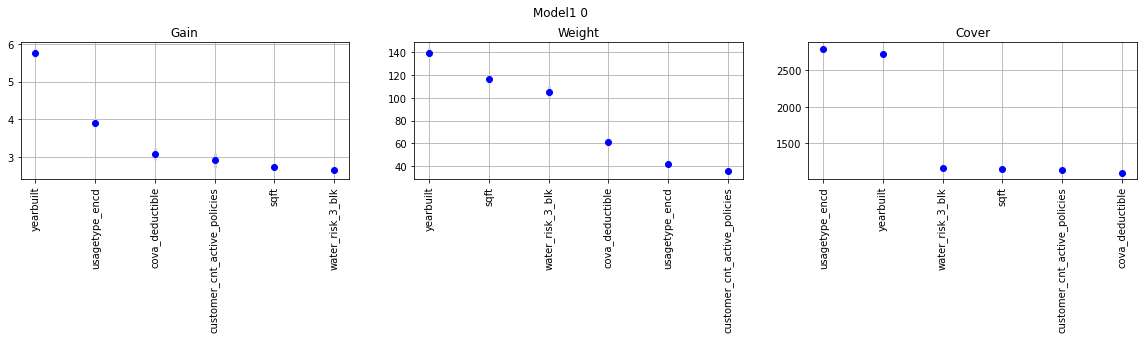

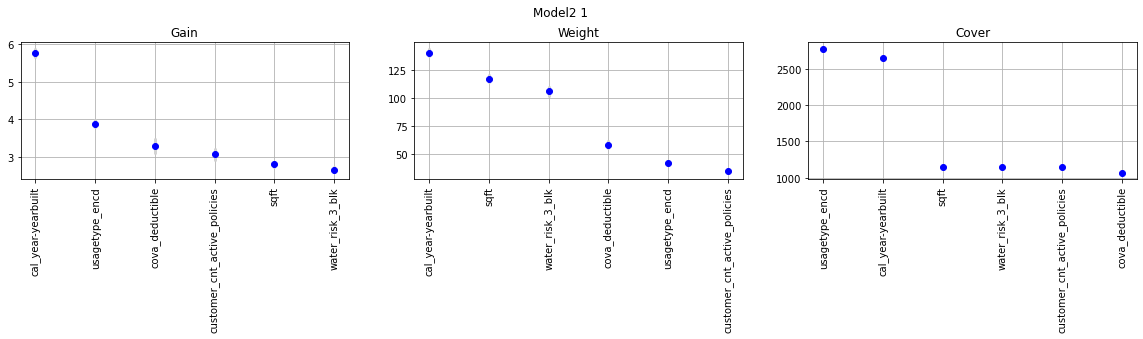

In [24]:
if len(BestModelFI): 
    lst_chart_filenames = list()
    for index, row in data_for_training.iterrows():
        if len(BestModelFI[( (BestModelFI['Model']==row['Model']) & (BestModelFI['ind']==index))])>0:
            data=BestModelFI[( (BestModelFI['Model']==row['Model']) & (BestModelFI['ind']==index))].sort_values('gain-mean',ascending=False)
            fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(20,5)) 
            fig.suptitle('%s %s'%(row['Model'],index))
            fig.subplots_adjust(bottom=0.5)
            
            ax = axs[0]
            ax.errorbar(data['feature'], data['gain-mean'], color = 'blue',  ecolor='lightgray', elinewidth=3, capsize=0,yerr=data['gain-sem'], fmt='o')
            ax.set_title('Gain')
            ax.set_xticklabels(data['feature'].values,rotation=90)
            ax.grid(axis='both')

 
            data=data.sort_values('weight-mean',ascending=False)
            ax = axs[1]
            ax.errorbar(data['feature'], data['weight-mean'], color = 'blue',  ecolor='lightgray', elinewidth=3, capsize=0,yerr=data['weight-sem'], fmt='o')
            ax.set_title('Weight')
            ax.set_xticklabels(data['feature'].values,rotation=90)
            ax.grid(axis='both')
         
                         
            data=data.sort_values('cover-mean',ascending=False)
            ax = axs[2]
            ax.errorbar(data['feature'], data['cover-mean'], color = 'blue',  ecolor='lightgray', elinewidth=3, capsize=0,yerr=data['weight-sem'], fmt='o')
            ax.set_title('Cover')
            ax.set_xticklabels(data['feature'].values,rotation=90)
            ax.grid(axis='both')
            chart_filename=temp_folder+'%s %s.png'%(row['Model'],index)
            lst_chart_filenames.append(chart_filename)
            fig.savefig(chart_filename,format='png')

In [25]:
if len(BestModelFI): 
    #Saving into the Experiment log file models results
    eu.SaveToExperimentLog(Experiments_file, '%s FI'%Experiment_name, BestModelFI)
    eu.SaveChartToExperimentLog(Experiments_file, '%s FI'%Experiment_name, len(BestModelFI), 20, lst_chart_filenames)

3.Visualization aggregated from folds best models scores

In [26]:
BestResults=pd.DataFrame()
for index, row in data_for_training.iterrows():
    if len(CVResults[( (CVResults['Model']==row['Model']) & (CVResults['ind']==index))])>0:
        #max or min depending on the score
        if Maximize:
            BestTestScore=CVResults[( (CVResults['Model']==row['Model']) & (CVResults['ind']==index))]['valid-%s-mean'%score].max()
        else:
            BestTestScore=CVResults[( (CVResults['Model']==row['Model']) & (CVResults['ind']==index))]['valid-%s-mean'%score].min()
        #even if there are more then 1 rows with the same max valid-...-mean use only first: head(1)
        BestModelResult=CVResults[( (CVResults['Model']==row['Model']) & (CVResults['ind']==index) & 
                                                       (CVResults['valid-%s-mean'%score]==BestTestScore))].head(1).copy()
        BestModelResult['TotalIterations']=CVResults[( (CVResults['Model']==row['Model']) & (CVResults['ind']==index))].shape[0]
        BestResults=pd.concat([BestResults,BestModelResult])
BestResults.reset_index(inplace=True)
BestResults.columns=['BestIteration','Model', 'ind']+folds_train_columns+['train-%s-mean'%score, 'train-%s-std'%score, 'train-%s-sem'%score]+folds_valid_columns+['valid-%s-mean'%score, 'valid-%s-std'%score, 'valid-%s-sem'%score,'TotalIterations']
BestResults=BestResults[['Model', 'ind','TotalIterations','BestIteration']+folds_train_columns+['train-%s-mean'%score, 'train-%s-std'%score, 'train-%s-sem'%score]+folds_valid_columns+['valid-%s-mean'%score, 'valid-%s-std'%score, 'valid-%s-sem'%score]]
BestResults

,Model,ind,TotalIterations,BestIteration,train-0-fold,train-1-fold,train-2-fold,train-3-fold,train-4-fold,train-5-fold,...,valid-3-fold,valid-4-fold,valid-5-fold,valid-6-fold,valid-7-fold,valid-8-fold,valid-9-fold,valid-gini-mean,valid-gini-std,valid-gini-sem
0,Model1,0,101,100,0.361144,0.358484,0.363123,0.362485,0.363164,0.361374,...,0.360741,0.338662,0.336388,0.334211,0.359947,0.352315,0.363044,0.351043,0.014167,0.00448
1,Model2,1,101,100,0.364841,0.362406,0.365870,0.363810,0.364776,0.363992,...,0.365323,0.342495,0.334358,0.337699,0.363451,0.348427,0.362218,0.352938,0.013407,0.00424


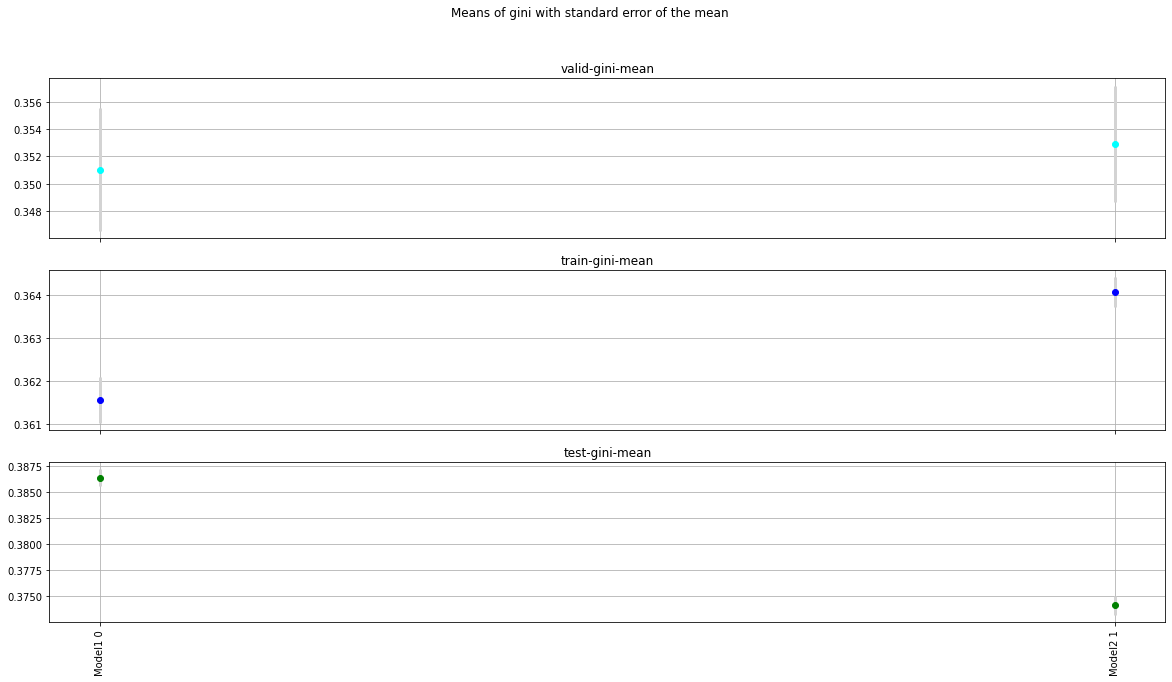

In [27]:
#Individual model scores means and standard errors
#For AUC ony
#Excluding from chart models which did not learn anything (0.5 is random guessing)
#data = BestResults[BestResults['valid-auc-mean']>0.5].copy()
#if len(ModelTestScores)>0:
#    data_test = ModelTestScores[ModelTestScores['mean']>0.5].copy()


data = BestResults.copy()
if len(ModelTestScores)>0:
    data_test = ModelTestScores.copy()    
#list of models for xticks
data['xticks']=data['Model']+' '+data['ind'].astype(str) 
xticks=data['xticks'].unique().tolist()


# The x position 
r1 = np.arange(len(data))
if len(ModelTestScores)>0:
    fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True,figsize=(20,10))
else:
    fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True,figsize=(20,10))
ax = axs[0]
ax.errorbar(r1, data['valid-%s-mean'%score], color = 'cyan',  ecolor='lightgray', elinewidth=3, capsize=0,yerr=data['valid-%s-sem'%score], fmt='o')
ax.set_title('valid-%s-mean'%score)
ax.grid(axis='both')
#ax.margins(x=2)
ax = axs[1]
ax.errorbar(r1, data['train-%s-mean'%score],  color = 'blue',  ecolor='lightgray', elinewidth=3,capsize=0, yerr=data['train-%s-sem'%score],  fmt='o')
ax.set_title('train-%s-mean'%score)
ax.set_xticks([r  for r in range(len(data))])
ax.set_xticklabels(xticks,rotation=90)
ax.grid(axis='both')
#ax.margins(x=2)
fig.suptitle('Means of %s with standard error of the mean'%score)
if len(data_test)>0:
    ax = axs[2]
    ax.errorbar(r1, data_test['mean'],  color = 'green',  ecolor='lightgray', elinewidth=3,capsize=0, yerr=data_test['sem'],  fmt='o')
    ax.set_title('test-%s-mean'%score)
    ax.set_xticks([r  for r in range(len(data_test))])
    ax.set_xticklabels(xticks,rotation=90)
    ax.grid(axis='both')
    #ax.margins(x=2)
    
lst_model_scores_chart_filenames=list()
chart_filename=temp_folder+'Models Scores.png'
lst_model_scores_chart_filenames.append(chart_filename)
fig.savefig(chart_filename,format='png')

4. Corrected t-test compares VALIDATION scores of individual folds in a choosen model to the rest of the models folds

In [28]:
#set a specific BaseModel name and index or just select with min or max score
#The rest of the models will be compared to baseModel and baseind
BaseModel='Model1'
BaseInd=0
#BaseModel=BestResults[BestResults['valid-%s-mean'%score]==BestResults['valid-%s-mean'%score].max()]['Model'].values[0]
#BaseInd=BestResults[BestResults['valid-%s-mean'%score]==BestResults['valid-%s-mean'%score].max()]['ind'].values[0]
BaseModelResults=BestResults[((BestResults['Model']==BaseModel) & (BestResults['ind']==BaseInd))][folds_valid_columns].values[0].tolist()
shapiro_test = stats.shapiro(BaseModelResults)
if shapiro_test.pvalue < alpha:
    BestResults['corrected t-test Comment'] = 'The null hypothesis that the data are normally distributed is rejected'
    BestResults['t-test Comment'] = 'The null hypothesis that the data are normally distributed is rejected'
else:
    BestResults['corrected t-test Comment'] = 'The data are normally distributed'
    BestResults['t-test Comment'] = 'The data are normally distributed'

In [29]:
#corrected t-test for each record in BestResults
for index, model in BestResults.iterrows():
    if ((model['Model']!=BaseModel) | (model['ind']!=BaseInd)):
        AnalyzedModelResults=model[folds_valid_columns].values.tolist()
        shapiro_test = stats.shapiro(AnalyzedModelResults)
        if shapiro_test.pvalue < alpha:
            BestResults.at[index,'corrected t-test Comment'] = 'The null hypothesis that the data are normally distributed is rejected'
        else:
            (t, critical_value, pvalue) = eu.corrected_paired_ttest(BaseModelResults,AnalyzedModelResults, n1, n2, alpha)
            BestResults.at[index,'corrected t-statistic']= t
            BestResults.at[index,'corrected pvalue'] = pvalue 
            if pvalue>=alpha:
                BestResults.at[index,'corrected t-test Comment'] = 'No difference with %s with %s significance level'%(BaseModel,alpha)
            else:
                BestResults.at[index,'corrected t-test Comment'] = 'There is a difference with %s with %s significance level'%(BaseModel,alpha)
BestResults[['Model','ind','valid-%s-mean'%score,'corrected t-statistic','corrected pvalue','corrected t-test Comment']]

,Model,ind,valid-gini-mean,corrected t-statistic,corrected pvalue,corrected t-test Comment
0,Model1,0,0.351043,NaN,NaN,The data are normally distributed
1,Model2,1,0.352938,2.960651,0.015943,There is a difference with Model1 with 0.05 si...


In [30]:
#joining the results of the experiment with the experiment configuration
BestResults = pd.concat([BestResults, data_for_training.drop('Model',axis=1)], axis=1)
BestResults

,Model,ind,TotalIterations,BestIteration,train-0-fold,train-1-fold,train-2-fold,train-3-fold,train-4-fold,train-5-fold,...,Training_data,Testing_data,Training_offset,Testing_offset,F1,F2,F3,F4,F5,F6
0,Model1,0,101,100,0.361144,0.358484,0.363123,0.362485,0.363164,0.361374,...,/home/kate/Research/Property/Data/Experiments/...,/home/kate/Research/Property/Data/Experiments/...,,,sqft,usagetype_encd,yearbuilt,water_risk_3_blk,customer_cnt_active_policies,cova_deductible
1,Model2,1,101,100,0.364841,0.362406,0.365870,0.363810,0.364776,0.363992,...,/home/kate/Research/Property/Data/Experiments/...,/home/kate/Research/Property/Data/Experiments/...,,,sqft,usagetype_encd,cal_year-yearbuilt,water_risk_3_blk,customer_cnt_active_policies,cova_deductible


5. Corrected Confidence interval of the difference between model VALIDATION scores

In [31]:
CI_name = list()
CI_mean = list()
CI_lower = list()
CI_upper = list()
for index, model in BestResults.iterrows():
    if ((model['Model']!=BaseModel) | (model['ind']!=BaseInd)):
        AnalyzedModelResults=model[folds_valid_columns].values.tolist()
        diff=[np.abs(y - x) for y, x in zip(BaseModelResults,AnalyzedModelResults)]
        CI=eu.corrected_confidence_interval(BaseModelResults,AnalyzedModelResults, n1, n2, 1-alpha)
        CI_name.append(model['Model']+' '+str(model['ind']))
        CI_mean.append(np.mean(diff))
        CI_lower.append(CI[0])
        CI_upper.append(CI[1])          
        BestResults.at[index,'BaseModel Diff mean'] = np.mean(diff)
        BestResults.at[index,'BaseModel Corrected CI lower'] = CI[0]
        BestResults.at[index,'BaseModel Corrected CI upper'] = CI[1]
CI_df = pd.DataFrame(list(zip(CI_name, CI_mean, CI_lower, CI_upper)), columns=['Model','mean','lower','upper'])

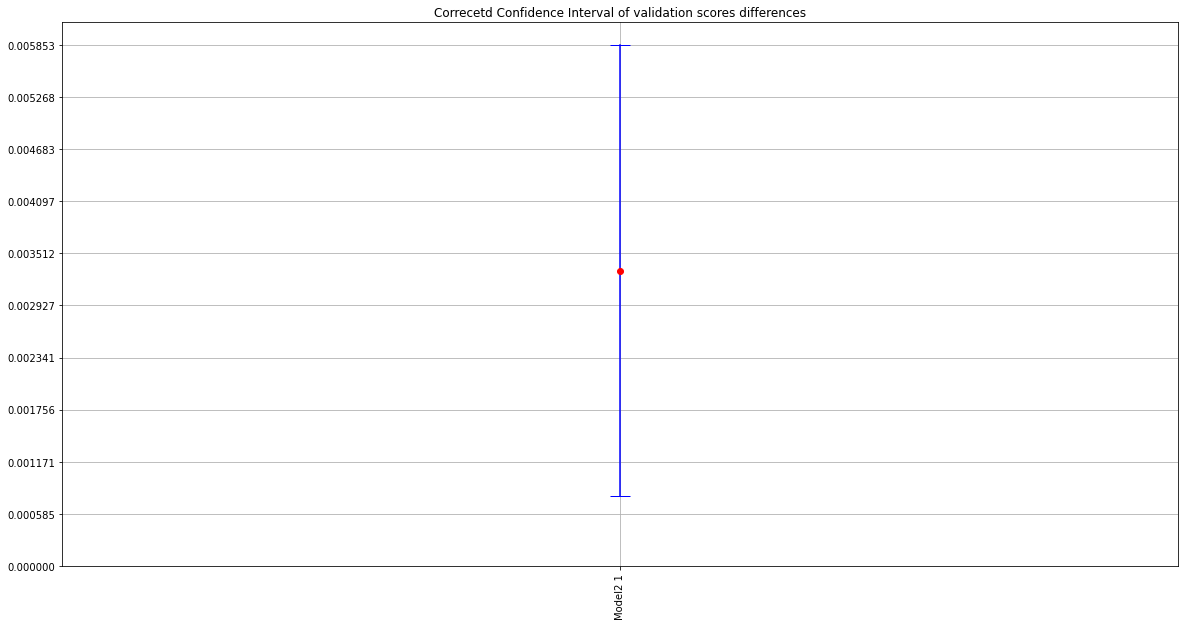

In [32]:
dim=np.arange(0,CI_df['upper'].max() + CI_df['upper'].max()/10,CI_df['upper'].max()/10)
plt.figure(figsize=(20,10))
for lower,mean,upper,x in zip(CI_df['lower'],CI_df['mean'],CI_df['upper'],range(len(CI_df))):
    plt.plot((x,x),(lower,upper),'r_-',markersize=20,color='blue')
    plt.plot(x,mean,'ro',color='red')
plt.xticks(range(len(CI_df)),list(CI_df['Model']),rotation=90)
plt.yticks(dim)
plt.grid(axis='both')

#plt.margins(x=2)
_=plt.title('Correcetd Confidence Interval of validation scores differences')
lst_chart_filenames=list()
chart_filename=temp_folder+'Correcetd Confidence Interval of validation scores differences.png'
lst_chart_filenames.append(chart_filename)

plt.savefig(chart_filename,format='png')

6. Students t-test compares VALIDATION scores of individual folds in a choosen model to the rest of the models folds

In [33]:
#t-test for each record in BestResults
for index, model in BestResults.iterrows():
    if ((model['Model']!=BaseModel) | (model['ind']!=BaseInd)):
        AnalyzedModelResults=model[folds_valid_columns].values.tolist()
        shapiro_test = stats.shapiro(AnalyzedModelResults)
        if shapiro_test.pvalue < alpha:
            BestResults.at[index,'corrected t-test Comment'] = 'The null hypothesis that the data are normally distributed is rejected'
        else:
            t=stats.ttest_rel(BaseModelResults,AnalyzedModelResults)
            BestResults.at[index,'t-statistic']= t.statistic
            BestResults.at[index,'pvalue'] = t.pvalue 
            if t.pvalue>=alpha:
                BestResults.at[index,'t-test Comment'] = 'No difference with %s with %s alpha'%(BaseModel,alpha)
            else:
                BestResults.at[index,'t-test Comment'] = 'There is a difference with %s with %s alpha'%(BaseModel,alpha)
BestResults[['Model','ind','valid-%s-mean'%score,'t-statistic','pvalue','t-test Comment']]

,Model,ind,valid-gini-mean,t-statistic,pvalue,t-test Comment
0,Model1,0,0.351043,NaN,NaN,The data are normally distributed
1,Model2,1,0.352938,-1.590547,0.146175,No difference with Model1 with 0.05 alpha


7. Confidence interval of the difference between model Validation  scores

In [34]:
CI_name = list()
CI_mean = list()
CI_lower = list()
CI_upper = list()
for index, model in BestResults.iterrows():
    if ((model['Model']!=BaseModel) | (model['ind']!=BaseInd)):
        AnalyzedModelResults=model[folds_valid_columns].values.tolist()
        diff=[np.abs(y - x) for y, x in zip(BaseModelResults,AnalyzedModelResults)]
        CI=stats.t.interval(1-alpha, len(diff)-1, loc=np.mean(diff), scale=stats.sem(diff))
        CI_name.append(model['Model']+' '+str(model['ind']))
        CI_mean.append(np.mean(diff))
        CI_lower.append(CI[0])
        CI_upper.append(CI[1])          
        BestResults.at[index,'BaseModel Diff mean'] = np.mean(diff)
        BestResults.at[index,'BaseModel Corrected CI lower'] = CI[0]
        BestResults.at[index,'BaseModel Corrected CI upper'] = CI[1]
CI_df = pd.DataFrame(list(zip(CI_name, CI_mean, CI_lower, CI_upper)), columns=['Model','mean','lower','upper'])

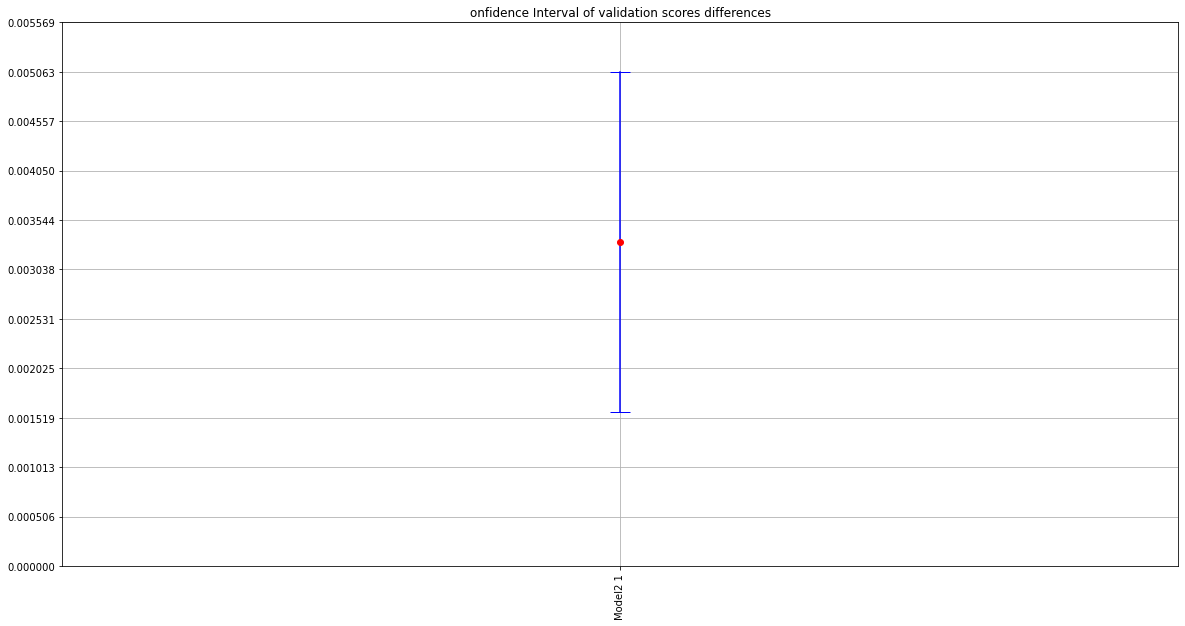

In [35]:
dim=np.arange(0,CI_df['upper'].max() + CI_df['upper'].max()/10,CI_df['upper'].max()/10)
plt.figure(figsize=(20,10))
for lower,mean,upper,x in zip(CI_df['lower'],CI_df['mean'],CI_df['upper'],range(len(CI_df))):
    plt.plot((x,x),(lower,upper),'r_-',markersize=20,color='blue')
    plt.plot(x,mean,'ro',color='red')
plt.xticks(range(len(CI_df)),list(CI_df['Model']),rotation=90)
plt.yticks(dim)
plt.grid(axis='both')

#plt.margins(x=2)
_=plt.title('onfidence Interval of validation scores differences')
chart_filename=temp_folder+'Confidence Interval of validation scores differences.png'
lst_chart_filenames.append(chart_filename)

plt.savefig(chart_filename,format='png')

In [36]:
#Saving into the Experiment log file models results
eu.SaveToExperimentLog(Experiments_file, '%s BestResults'%Experiment_name, BestResults)
eu.SaveChartToExperimentLog(Experiments_file, '%s BestResults'%Experiment_name, len(BestResults), 20, lst_chart_filenames)
eu.SaveChartToExperimentLog(Experiments_file, '%s BestResults'%Experiment_name, len(BestResults)+100, 20, lst_model_scores_chart_filenames) 

8. t-test compares TEST scores of individual folds in a choosen model to the rest of the models folds

In [37]:
#set a specific BaseModel name and index or just select with min or max score
#The rest of the models will be compared to baseModel and baseind
if len(ModelTestScores)>0:
    #BaseModel=ModelTestScores[ModelTestScores['mean']==ModelTestScores['mean'].max()]['Model'].values[0]
    #BaseInd=ModelTestScores[ModelTestScores['mean']==ModelTestScores['mean'].max()]['ind'].values[0]
    BaseModel='Model1'
    BaseInd=0
    BaseModelResults=ModelTestScores[((ModelTestScores['Model']==BaseModel) & (ModelTestScores['ind']==BaseInd))][folds_test_columns].values[0].tolist()
    shapiro_test = stats.shapiro(BaseModelResults)
    if shapiro_test.pvalue < alpha:
        ModelTestScores['Comment'] = 'The null hypothesis that the data are normally distributed is rejected'
    else:
        ModelTestScores['Comment'] = 'The data are normally distributed'
                

In [38]:
#t-test for each record in BestResults
if len(ModelTestScores)>0:
    for index, model in ModelTestScores.iterrows():
        if ((model['Model']!=BaseModel) | (model['ind']!=BaseInd)):
            AnalyzedModelResults=model[folds_test_columns].values.tolist()
            shapiro_test = stats.shapiro(AnalyzedModelResults)
            if shapiro_test.pvalue < alpha:
                ModelTestScores.at[index,'Comment'] = 'The null hypothesis that the data are normally distributed is rejected'
            else:
                t=stats.ttest_rel(BaseModelResults,AnalyzedModelResults)
                ModelTestScores.at[index,'t-statistic']= t.statistic
                ModelTestScores.at[index,'pvalue'] = t.pvalue 
                if t.pvalue>=alpha:
                    ModelTestScores.at[index,'Comment'] = 'No difference with %s with %s significance level'%(BaseModel,alpha)
                else:
                    ModelTestScores.at[index,'Comment'] = 'There is a difference with %s with %s significance level'%(BaseModel,alpha)
        else:
            ModelTestScores.at[index,'t-statistic']= np.nan
            ModelTestScores.at[index,'pvalue'] = np.nan
ModelTestScores[['Model','mean','t-statistic','pvalue','Comment']]

,Model,mean,t-statistic,pvalue,Comment
index,,,,,
0,Model1,0.386346,NaN,NaN,The data are normally distributed
1,Model2,0.374100,23.352884,2.305271e-09,There is a difference with Model1 with 0.05 si...


9. Confidence interval of the difference between model TEST scores

In [39]:
if len(ModelTestScores)>0:
    CI_name = list()
    CI_mean = list()
    CI_lower = list()
    CI_upper = list()
    for index, model in ModelTestScores.iterrows():
        if ((model['Model']!=BaseModel) | (model['ind']!=BaseInd)):
            AnalyzedModelResults=model[folds_test_columns].values.tolist()
            diff=[np.abs(y - x) for y, x in zip(BaseModelResults,AnalyzedModelResults)]
            CI=stats.t.interval(1-alpha, len(diff)-1, loc=np.mean(diff), scale=stats.sem(diff))
            CI_name.append(model['Model']+' '+str(model['ind']) )
            CI_mean.append(np.mean(diff))
            CI_lower.append(CI[0])
            CI_upper.append(CI[1])  
            ModelTestScores.at[index,'BaseModel Diff mean'] = np.mean(diff)
            ModelTestScores.at[index,'BaseModel Corrected CI lower'] = CI[0]
            ModelTestScores.at[index,'BaseModel Corrected CI upper'] = CI[1]                       
    CI_df = pd.DataFrame(list(zip(CI_name, CI_mean, CI_lower, CI_upper)), columns=['Model','mean','lower','upper'])

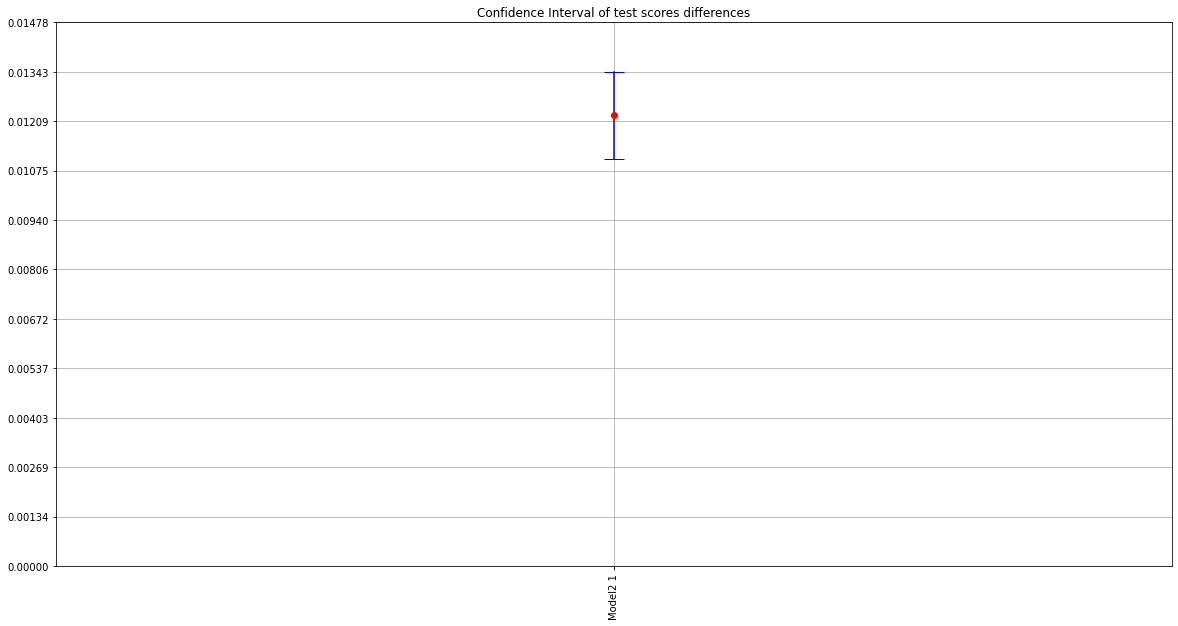

In [40]:
if len(ModelTestScores)>0:
    plt.figure(figsize=(20,10))
    dim=np.arange(0,CI_df['upper'].max() + CI_df['upper'].max()/10,CI_df['upper'].max()/10)
    for lower,mean,upper,x in zip(CI_df['lower'],CI_df['mean'],CI_df['upper'],range(len(CI_df))):
        plt.plot((x,x),(lower,upper),'r_-',markersize=20,color='blue')
        plt.plot(x,mean,'ro',color='red')
    plt.xticks(range(len(CI_df)),list(CI_df['Model']),rotation=90)
    plt.yticks(dim)
    plt.grid(axis='both')
    #plt.margins(x=2)
    _=plt.title('Confidence Interval of test scores differences')
    lst_chart_filenames=list()
    chart_filename=temp_folder+'Confidence Interval of test scores differences.png'
    lst_chart_filenames.append(chart_filename)
    plt.savefig(chart_filename,format='png')

The difference between the means of model scores for the entire population present in this confidence interval. If there is no difference, then the interval contains zero (0). If zero is NOT in the range of values, the difference is statistically significant. 

In [45]:
if len(ModelTestScores)>0:
    #joining the results of the experiment with the experiment configuration
    ModelTestScores = pd.concat([ModelTestScores, data_for_training.drop('Model',axis=1)], axis=1)

    #Saving into the Experiment log file models results
    eu.SaveToExperimentLog(Experiments_file, '%s TestScores '%Experiment_name, ModelTestScores)
    eu.SaveChartToExperimentLog(Experiments_file, '%s TestScores '%Experiment_name, len(ModelTestScores), 20, lst_chart_filenames)

10. Training and validation errors (output from the model) to estimate overfitting

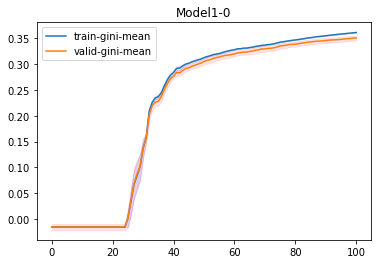

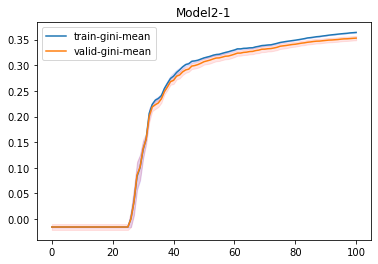

In [42]:
lst_chart_filenames=list()
for index, row in data_for_training.iterrows():
    if len(CVResults[( (CVResults['Model']==row['Model']) & (CVResults['ind']==index))])>0:
        data=CVResults[( (CVResults['Model']==row['Model']) & (CVResults['ind']==index))]
        ax=data[['train-%s-mean'%score,'valid-%s-mean'%score]].plot(title=row['Model']+'-'+str(index))
        ax.fill_between(data.index.values, (data['train-%s-mean'%score].values-data['train-%s-sem'%score].values), (data['train-%s-mean'%score].values + data['train-%s-sem'%score].values), color='b', alpha=.1)
        ax.fill_between(data.index.values, (data['valid-%s-mean'%score].values-data['valid-%s-sem'%score].values), (data['valid-%s-mean'%score].values + data['valid-%s-sem'%score].values), color='r', alpha=.1)
        chart_filename=temp_folder+'train-valid scores %s-%s.png'%(row['Model'],index)
        lst_chart_filenames.append(chart_filename)
        ax.figure.savefig(chart_filename,format='png')
  

In [43]:
#Saving into the Experiment log file models results
eu.SaveToExperimentLog(Experiments_file, '%s CVResults'%Experiment_name, CVResults.tail(10))
eu.SaveChartToExperimentLog(Experiments_file, '%s CVResults'%Experiment_name, 10, 20, lst_chart_filenames)

In [44]:
#Saving models artifacts into the Experiment Log file
eu.SaveToExperimentLog(Experiments_file, '%s ModelFiles'%Experiment_name, ModelFiles)

### Hyperparameters visualizations 

In [ ]:
df=BestResults[['train-%s-mean'%score,'valid-%s-mean'%score,'colsample_bylevel','colsample_bytree','eta','subsample','max_depth','reg_alpha']]
df['diff']=100*(df['train-%s-mean'%score] - df['valid-%s-mean'%score])
df = df.drop('train-%s-mean'%score, 1)
df=df[['colsample_bylevel','colsample_bytree','eta','subsample','max_depth','reg_alpha','diff','valid-%s-mean'%score]]
df

In [ ]:
import plotly.express as px
fig = px.parallel_coordinates(df, ['colsample_bylevel','colsample_bytree','eta','subsample','max_depth','reg_alpha','diff','valid-%s-mean'%score], color='valid-%s-mean'%score
                             ,color_continuous_scale=px.colors.diverging.Tealrose,
                             color_continuous_midpoint=0.34)
fig.show()